**Access Dataset from Google Drive**

In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/Alzheimer_Project

Mounted at /gdrive
/gdrive/My Drive/Alzheimer_Project


In [2]:
%ls

 AD_Inception_V3.ipynb                    test/
 AD_Model_Inception_V3.h5                 train/
 AD_Model_VGG19.h5                       'VGG19_Classification Report.png'
 AD_VGG19.ipynb                           VGG19_Confusion_Matrix.png
 Inception_V3_Classification_Report.png   VGG19_ct_accuracy.png
 Inception_V3_Confusion_Matrix.png        VGG19_dem_loss.png
 Inception_V3_ct_accuracy.png             VGG19_ROC.png
 Inception_V3_dem_loss.png                Weights_AD_Model_VGG19.hdf5
 Inception_V3_ROC.png


**Importing Libraries and dependencies**

In [20]:
from builtins import range, input

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, AveragePooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt


import cv2
from glob import glob

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical

In [4]:
IMAGE_SIZE = [229,229]

epochs = 500
batch_size = 64

# **Image data Preprocessing**

***Classifying Categories***



In [5]:
dement_path = '/gdrive/My Drive/Alzheimer_Project/train/MildDemented'
nondement_path = '/gdrive/My Drive/Alzheimer_Project/train/NonDemented'

In [6]:
NonDemfiles = glob( nondement_path +'/*' )
Demfiles = glob( dement_path + '/*' )

In [7]:
print("First 5 NonDem Files: ",NonDemfiles[0:5])
print("Total Count: ",len(NonDemfiles))
print("First 5 MildDem Files: ",Demfiles[0:5])
print("Total Count: ",len(Demfiles))

First 5 NonDem Files:  ['/gdrive/My Drive/Alzheimer_Project/train/NonDemented/nonDem210.jpg', '/gdrive/My Drive/Alzheimer_Project/train/NonDemented/nonDem204.jpg', '/gdrive/My Drive/Alzheimer_Project/train/NonDemented/nonDem205.jpg', '/gdrive/My Drive/Alzheimer_Project/train/NonDemented/nonDem234.jpg', '/gdrive/My Drive/Alzheimer_Project/train/NonDemented/nonDem209.jpg']
Total Count:  500
First 5 MildDem Files:  ['/gdrive/My Drive/Alzheimer_Project/train/MildDemented/mildDem335.jpg', '/gdrive/My Drive/Alzheimer_Project/train/MildDemented/mildDem255.jpg', '/gdrive/My Drive/Alzheimer_Project/train/MildDemented/mildDem233.jpg', '/gdrive/My Drive/Alzheimer_Project/train/MildDemented/mildDem292.jpg', '/gdrive/My Drive/Alzheimer_Project/train/MildDemented/mildDem339.jpg']
Total Count:  500


In [8]:
Dem_labels = []
NonDem_labels = []

Dem_images=[]
NonDem_images=[]

for i in range(len(Demfiles)):
  image = cv2.imread(Demfiles[i]) 
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
  image = cv2.resize(image,(229,229)) 
  Dem_images.append(image) 
  Dem_labels.append('Demented') 
for i in range(len(NonDemfiles)):
  image = cv2.imread(NonDemfiles[i])
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = cv2.resize(image,(229,229))
  NonDem_images.append(image)
  NonDem_labels.append('NonDemented')

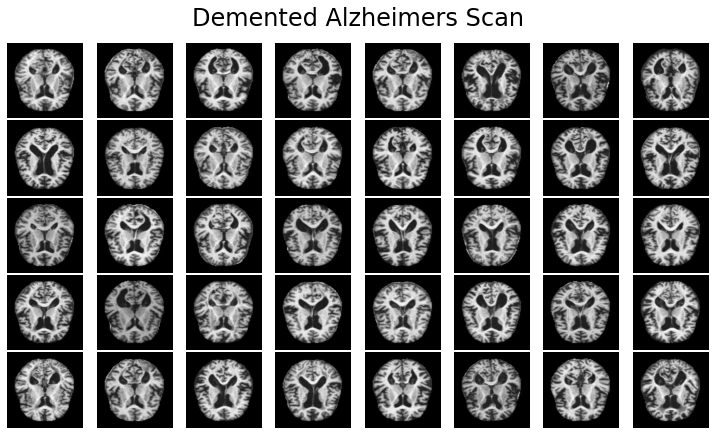

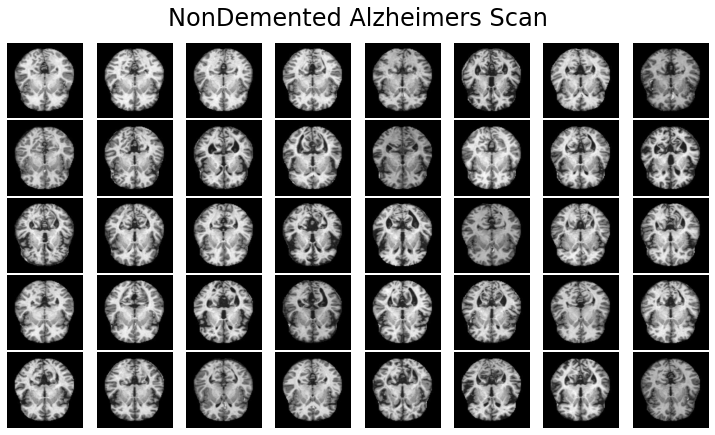

In [9]:
def plot_images(images, title):
    nrows, ncols = 5, 8
    figsize = [10, 6]

    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, facecolor=(1, 1, 1))

    for i, axi in enumerate(ax.flat):
        axi.imshow(images[i])
        axi.set_axis_off()

    plt.suptitle(title, fontsize=24)
    plt.tight_layout(pad=0.2, rect=[0, 0, 1, 0.9])
    plt.show()
plot_images(Dem_images, 'Demented Alzheimers Scan')
plot_images(NonDem_images, 'NonDemented Alzheimers Scan')

In [10]:
Dem_images = np.array(Dem_images) / 255
NonDem_images = np.array(NonDem_images) / 255

***Splitting Dataset into test set and training set***

In [11]:
Dem_x_train, Dem_x_test, Dem_y_train, Dem_y_test = train_test_split(
    Dem_images, Dem_labels, test_size=0.2)
NonDem_x_train, NonDem_x_test, NonDem_y_train, NonDem_y_test = train_test_split(
    NonDem_images, NonDem_labels, test_size=0.2)


X_train = np.concatenate((NonDem_x_train, Dem_x_train), axis=0)
X_test = np.concatenate((NonDem_x_test, Dem_x_test), axis=0)
y_train = np.concatenate((NonDem_y_train, Dem_y_train), axis=0)
y_test = np.concatenate((NonDem_y_test, Dem_y_test), axis=0)

y_train = LabelBinarizer().fit_transform(y_train)
y_train = to_categorical(y_train)

y_test = LabelBinarizer().fit_transform(y_test)
y_test = to_categorical(y_test)

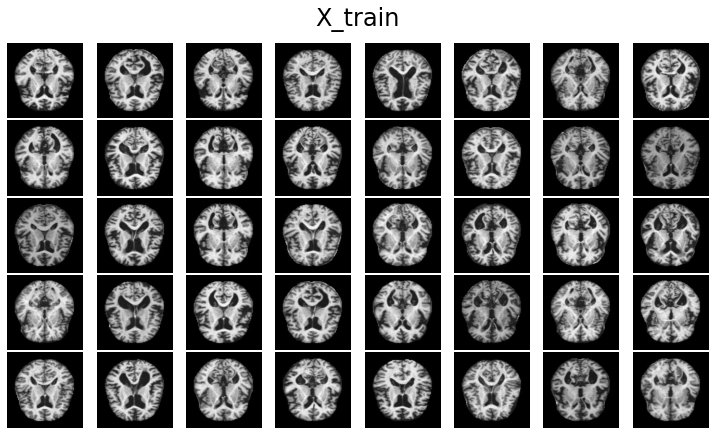

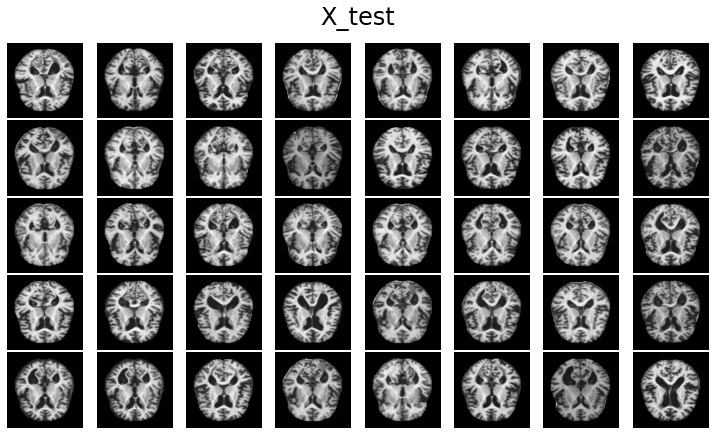

In [12]:
plot_images(Dem_x_train, 'X_train')
plot_images(Dem_x_test, 'X_test')

***Building and Visualizing VGG19 Model***

In [13]:
VGGmodel = VGG19(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(229, 229, 3)))

outputs = VGGmodel.output
outputs = Flatten(name="flatten")(outputs)
outputs = Dropout(0.4)(outputs)
outputs = Dense(2, activation="softmax")(outputs)

model = Model(inputs=VGGmodel.input, outputs=outputs)

for layer in VGGmodel.layers:
    layer.trainable = False

model.compile(
        loss='categorical_crossentropy', 
        optimizer='adam', 
        metrics=['accuracy']
)

80142336/80134624 [==============================] - 1s 0us/step


In [14]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 229, 229, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 229, 229, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 229, 229, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 114, 114, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 114, 114, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 114, 114, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 57, 57, 128)       0     

# **Image Augmentation**

**Training images at various angles, flips,positions etc.**

In [ ]:
train_aug = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

**Training the model**

In [ ]:
history = model.fit(train_aug.flow(X_train, y_train, batch_size=batch_size),
                    validation_data=(X_test, y_test),
                    validation_steps=len(X_test) / batch_size,
                    steps_per_epoch=len(X_train) / batch_size,
                    epochs=epochs)

Epoch 1/500
5/5 [==============================] - 49s 2s/step - loss: 1.6148 - accuracy: 0.5209 - val_loss: 1.0895 - val_accuracy: 0.5000
Epoch 2/500
5/5 [==============================] - 4s 870ms/step - loss: 1.1758 - accuracy: 0.5164 - val_loss: 0.5638 - val_accuracy: 0.7000
Epoch 3/500
5/5 [==============================] - 4s 869ms/step - loss: 0.7426 - accuracy: 0.6097 - val_loss: 0.7483 - val_accuracy: 0.5750
Epoch 4/500
5/5 [==============================] - 4s 869ms/step - loss: 0.7043 - accuracy: 0.6285 - val_loss: 0.5685 - val_accuracy: 0.6875
Epoch 5/500
5/5 [==============================] - 4s 860ms/step - loss: 0.6058 - accuracy: 0.6918 - val_loss: 0.4199 - val_accuracy: 0.8125
Epoch 6/500
5/5 [==============================] - 4s 870ms/step - loss: 0.5526 - accuracy: 0.7434 - val_loss: 0.4781 - val_accuracy: 0.8000
Epoch 7/500
5/5 [==============================] - 4s 873ms/step - loss: 0.4650 - accuracy: 0.7915 - val_loss: 0.4249 - val_accuracy: 0.8000
Epoch 8/500
5/5

In [ ]:
model.save('AD_Model_VGG19.h5')
model.save_weights('Weights_AD_Model_VGG19.hdf5')

***Predicting trained model on test set***

In [15]:
model = load_model('AD_Model_VGG19.h5')

In [16]:
y_pred = model.predict(X_test, batch_size=batch_size)

***Visualizing predicted classes***

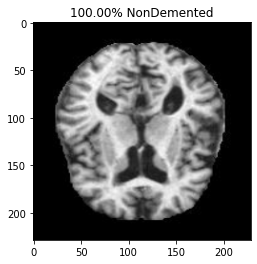

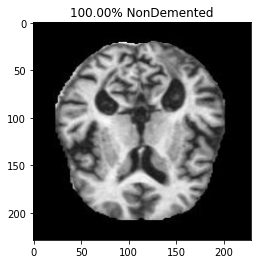

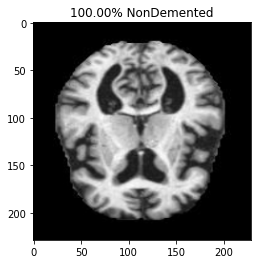

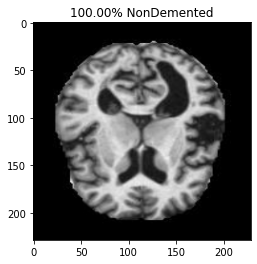

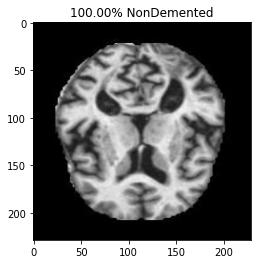

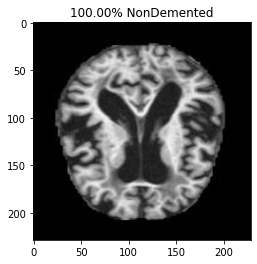

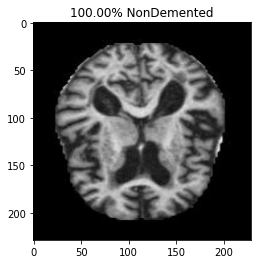

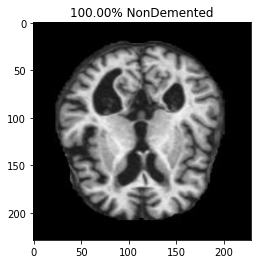

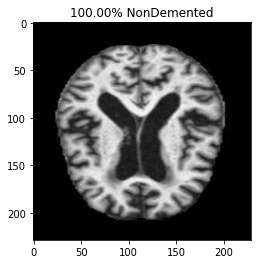

In [17]:
prediction=y_pred[1:10]
for index, probability in enumerate(prediction):
  if probability.item(0) > 0.5:
        plt.title('%.2f' % (probability.item(0)*100) + '% Demented')
  else:
        plt.title('%.2f' % ((1-probability.item(0))*100) + '% NonDemented')
  plt.style.reload_library
  plt.imshow(Dem_images[index])
  plt.show()

***ROC Graph***

In [18]:
y_pred_bin,y_test_bin=None,None
y_pred_bin = np.argmax(y_pred, axis=1)
y_test_bin = np.argmax(y_test, axis=1)

AUC: 0.880


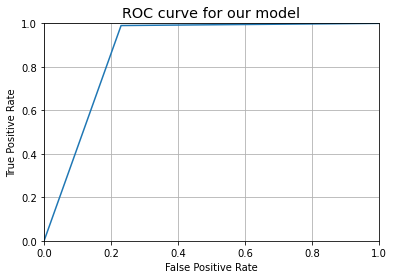

In [22]:
fpr, tpr, thresholds = roc_curve(y_test_bin, y_pred_bin)
auc = roc_auc_score(y_test_bin, y_pred_bin)
print('AUC: %.3f' % auc)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for our model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.savefig('VGG19_ROC.png')
plt.grid(True)

Confusion Matrix without Normalization


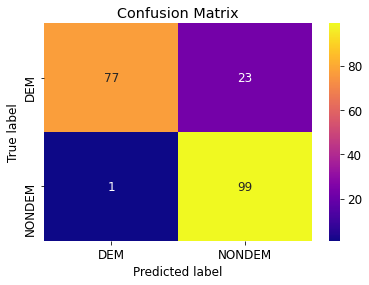

Confusion Matrix with Normalized Values


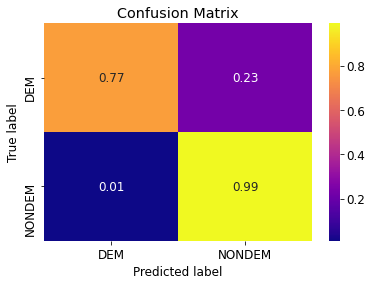

In [23]:
def plot_confusion_matrix(normalize):
  classes = ['DEM','NONDEM']
  tick_marks = [0.5,1.5]
  cn = confusion_matrix(y_test_bin, y_pred_bin,normalize=normalize)
  sns.heatmap(cn,cmap='plasma',annot=True)
  plt.xticks(tick_marks, classes)
  plt.yticks(tick_marks, classes)
  plt.title('Confusion Matrix')
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.savefig('VGG19_Confusion_Matrix.png')
  plt.show()
 
print('Confusion Matrix without Normalization')
plot_confusion_matrix(normalize=None)
 
print('Confusion Matrix with Normalized Values')
plot_confusion_matrix(normalize='true')

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test_bin, y_pred_bin))

              precision    recall  f1-score   support

           0       1.00      0.70      0.82       100
           1       0.77      1.00      0.87       100

    accuracy                           0.85       200
   macro avg       0.88      0.85      0.85       200
weighted avg       0.88      0.85      0.85       200



In [ ]:
plt.figure(figsize=(10,10))
 
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
 
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
 
plt.legend(['Training', 'Testing'])
plt.savefig('VGG19_ct_accuracy.png')
plt.show()

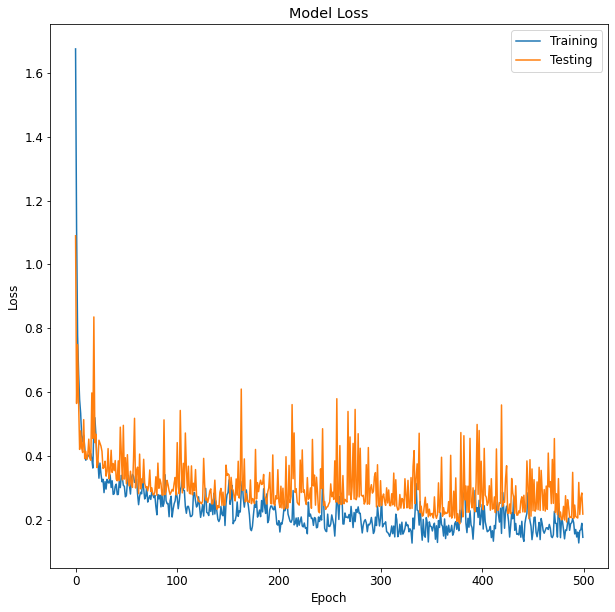

In [ ]:
plt.figure(figsize=(10,10))
 
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
 
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
 
plt.legend(['Training', 'Testing'])
plt.savefig('VGG19_dem_loss.png')
plt.show()